In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter


In [2]:
# Load Data
date = "20230802"
ds = xr.open_dataset(f"/home/alubianashari/RAQMS_CloudMasked_GEMS/tracer.compare.{date}.nc")

In [3]:
ds

<xarray.Dataset> Size: 6MB
Dimensions:           (lat: 540, lon: 750)
Coordinates:
  * lat               (lat) float64 4kB 47.95 47.85 47.75 ... -5.75 -5.85 -5.95
  * lon               (lon) float64 6kB 70.05 70.15 70.25 ... 144.7 144.8 144.9
Data variables:
    no2_daily_avg     (lat, lon) float32 2MB ...
    no2_cloud_masked  (lat, lon) float32 2MB ...
    gems_no2          (lat, lon) float64 3MB ...

In [4]:
raqms = ds["no2_cloud_masked"].values.flatten()
gems = ds["gems_no2"].values.flatten()

#valid if non nan values both raqms and gems
valid = ~np.isnan(raqms) & ~np.isnan(gems)
raqms_valid = raqms[valid]
gems_valid = gems[valid]  

print(len(raqms_valid))
print(len(gems_valid))


273342
273342


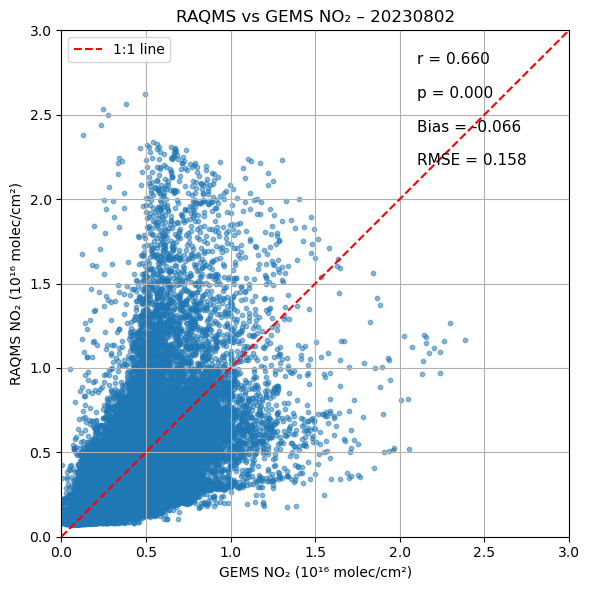

In [5]:
r, p = pearsonr(gems_valid, raqms_valid)
bias = np.mean(raqms_valid - gems_valid)
rmse = np.sqrt(np.mean((raqms_valid - gems_valid) ** 2))

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(gems_valid, raqms_valid, s=10, alpha=0.5)
plt.plot([0, 3], [0, 3], 'r--', label="1:1 line")

plt.xlabel("GEMS NO₂ (10¹⁶ molec/cm²)")
plt.ylabel("RAQMS NO₂ (10¹⁶ molec/cm²)")
plt.title(f"RAQMS vs GEMS NO₂ – {date}")
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)

plt.text(2.1, 2.8, f"r = {r:.3f}", fontsize=11)
plt.text(2.1, 2.6, f"p = {p:.3f}", fontsize=11)
plt.text(2.1, 2.4, f"Bias = {bias:.3f}", fontsize=11)
plt.text(2.1, 2.2, f"RMSE = {rmse:.3f}", fontsize=11)

plt.legend()
plt.tight_layout()
plt.show()

In [5]:
path = "/home/alubianashari/RAQMS_CloudMasked_GEMS/"
files = sorted(glob.glob(os.path.join(path, "tracer.compare.202308*.nc")))

# list to hold all data
raqms_all = []
gems_all = []

for f in files:
    ds = xr.open_dataset(f)
    raqms = ds["no2_cloud_masked"].values.flatten()
    gems = ds["gems_no2"].values.flatten()
    valid = ~np.isnan(raqms) & ~np.isnan(gems) #valid if non nan values both raqms and gems
    raqms_all.append(raqms[valid])
    gems_all.append(gems[valid])

# combined array
raqms_all = np.concatenate(raqms_all)
gems_all = np.concatenate(gems_all)

# statistics
r, p = pearsonr(gems_all, raqms_all)
bias = np.mean(raqms_all - gems_all)
rmse = np.sqrt(np.mean((raqms_all - gems_all) ** 2))

/tmp/ipykernel_2559064/3529105871.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_2559064/3529105871.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_dir, "scatter_plot.png"), facecolor='white', bbox_inches='tight')
/home/alubianashari/miniconda3/envs/aqms/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


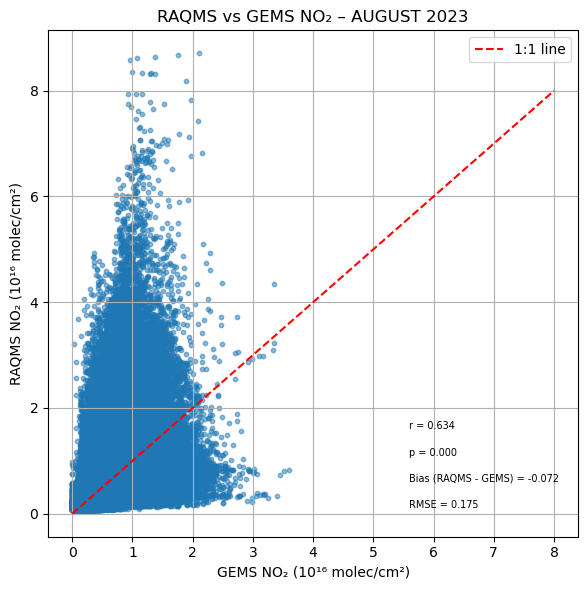

In [7]:
output_dir = "GEMS_stats"
os.makedirs(output_dir, exist_ok=True)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(gems_all, raqms_all, s=10, alpha=0.5)
plt.plot([0, 8], [0, 8], 'r--', label="1:1 line")

plt.xlabel("GEMS NO₂ (10¹⁶ molec/cm²)")
plt.ylabel("RAQMS NO₂ (10¹⁶ molec/cm²)")
plt.title(f"RAQMS vs GEMS NO₂ – AUGUST 2023")
plt.grid(True)
#plt.xlim(0, 5)
#plt.ylim(0, 5)

plt.text(5.6, 1.6, f"r = {r:.3f}", fontsize=7)
plt.text(5.6, 1.1, f"p = {p:.3f}", fontsize=7)
plt.text(5.6, 0.6, f"Bias (RAQMS - GEMS) = {bias:.3f}", fontsize=7)
plt.text(5.6, 0.1, f"RMSE = {rmse:.3f}", fontsize=7)

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "scatter_plot.png"), facecolor='white', bbox_inches='tight')
plt.show()


In [8]:
# BIAS MAPS

path = "/home/alubianashari/RAQMS_CloudMasked_GEMS/"
files = sorted(glob.glob(os.path.join(path, "tracer.compare.202308*.nc")))
output_dir = "RAQMS_BiasMaps_GEMS"
os.makedirs(output_dir, exist_ok=True)

for f in files:
    ds = xr.open_dataset(f)
    date = os.path.basename(f).split(".")[2]

    raqms = ds["no2_cloud_masked"].values
    gems = ds["gems_no2"].values
    lat = ds["lat"].values
    lon = ds["lon"].values

    # Compute bias: RAQMS - GEMS
    bias_map = raqms - gems
    vmin, vmax = -1, 1 

    # Plot
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([70, 145, -6, 48], crs=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale('10m'))
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.LAKES.with_scale('10m'), edgecolor='black', facecolor='none')

    im = ax.pcolormesh(lon, lat, bias_map, cmap="bwr", vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    plt.colorbar(im, ax=ax, orientation='horizontal', label="RAQMS − GEMS NO₂\n(10¹⁶ molec/cm²)", fraction=0.046, pad=0.1)

    ax.set_title(f"RAQMS − GEMS NO₂ Map – {date}")
    ax.set_xticks(np.arange(70, 150, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-5, 50, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # Save
    plt.savefig(f"{output_dir}/BiasMap_{date}.png", bbox_inches="tight")
    plt.close()

print(f"\done")


\done


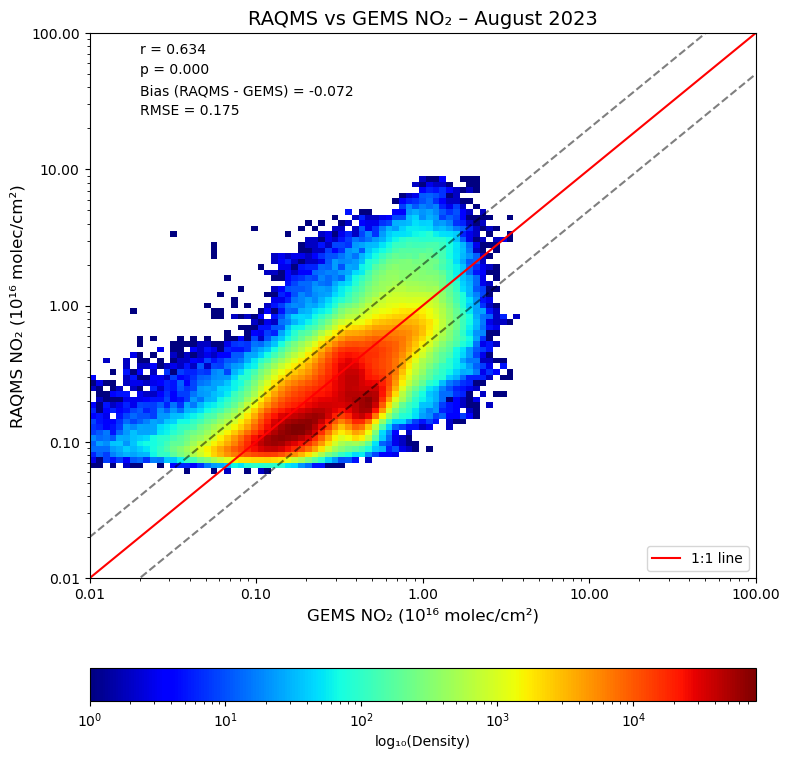

In [11]:
output_dir = "GEMS_stats"

# statistics
r, p = pearsonr(gems_all, raqms_all)
bias = np.mean(raqms_all - gems_all)
rmse = np.sqrt(np.mean((raqms_all - gems_all)**2))

# histogram bins
# log-spaced bins for better visualization of the data distribution
x_edges = np.logspace(-2, 2, 100)  # 0.01 to 100
y_edges = np.logspace(-2, 2, 100)

# histogram
H, xedges, yedges = np.histogram2d(gems_all, raqms_all, bins=[x_edges, y_edges])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
mesh = ax.pcolormesh(xedges, yedges, H.T, norm=LogNorm(), cmap='jet')

# axis
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain')
ax.set_xticks([0.01, 0.1, 1, 10, 100])
ax.set_yticks([0.01, 0.1, 1, 10, 100])
ax.tick_params(axis='both', which='major', labelsize=10)

# Labels and title
ax.set_xlabel('GEMS NO₂ (10¹⁶ molec/cm²)', fontsize=12)
ax.set_ylabel('RAQMS NO₂ (10¹⁶ molec/cm²)', fontsize=12)
ax.set_title('RAQMS vs GEMS NO₂ – August 2023', fontsize=14)

# 1:1 reference line, RAQMS = GEMS
ref_line = np.logspace(-2, 2, 100)
ax.plot(ref_line, ref_line, 'r-', linewidth=1.5, label='1:1 line')
# bias lines
ax.plot(ref_line, 2 * ref_line, 'k--', alpha=0.5) # where y = 2x, RAQMS = 2 * GEMS
ax.plot(ref_line, 0.5 * ref_line, 'k--', alpha=0.5) # where y = 0.5x

plt.text(0.02, 70, f"r = {r:.3f}", fontsize=10)
plt.text(0.02, 50, f"p = {p:.3f}", fontsize=10)
plt.text(0.02, 35, f"Bias (RAQMS - GEMS) = {bias:.3f}", fontsize=10)
plt.text(0.02, 25, f"RMSE = {rmse:.3f}", fontsize=10)

# Colorbar
cb = plt.colorbar(mesh, orientation='horizontal', pad=0.12)
cb.set_label('log₁₀(Density)')

# Legend
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "density_plot.png"), facecolor='white', bbox_inches='tight')
plt.show()


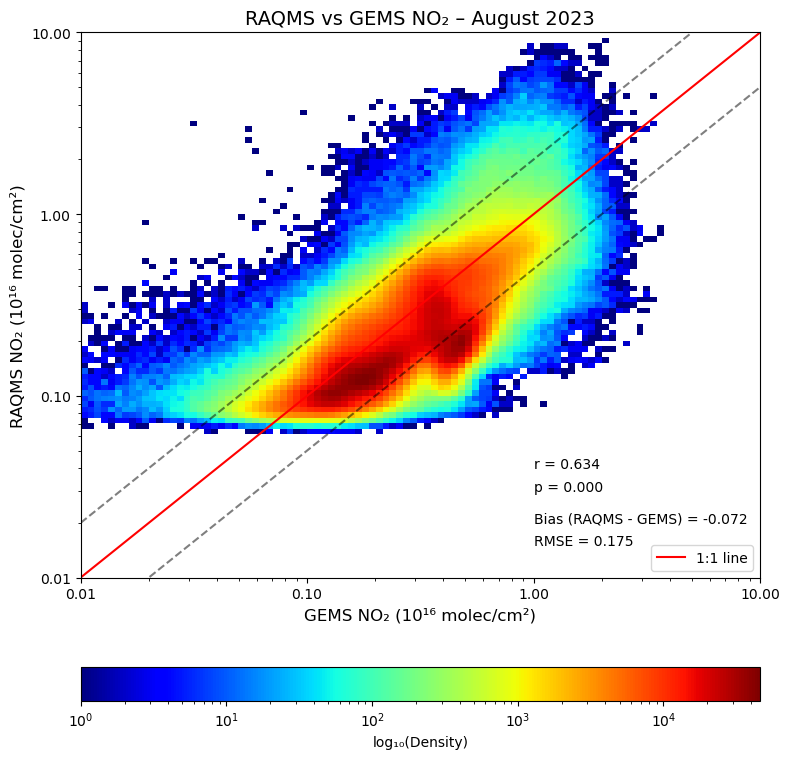

In [12]:
output_dir = "GEMS_stats"

# statistics
r, p = pearsonr(gems_all, raqms_all)
bias = np.mean(raqms_all - gems_all)
rmse = np.sqrt(np.mean((raqms_all - gems_all)**2))

# histogram bins
# log-spaced bins for better visualization of the data distribution
x_edges = np.logspace(-2, 1, 100)  # 0.01 to 10
y_edges = np.logspace(-2, 1, 100)

# histogram
H, xedges, yedges = np.histogram2d(gems_all, raqms_all, bins=[x_edges, y_edges])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
mesh = ax.pcolormesh(xedges, yedges, H.T, norm=LogNorm(), cmap='jet')

# axis
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 10)
ax.set_ylim(0.01, 10)

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain')
ax.set_xticks([0.01, 0.1, 1, 10])
ax.set_yticks([0.01, 0.1, 1, 10])
ax.tick_params(axis='both', which='major', labelsize=10)

# Labels and title
ax.set_xlabel('GEMS NO₂ (10¹⁶ molec/cm²)', fontsize=12)
ax.set_ylabel('RAQMS NO₂ (10¹⁶ molec/cm²)', fontsize=12)
ax.set_title('RAQMS vs GEMS NO₂ – August 2023', fontsize=14)

# 1:1 reference line, RAQMS = GEMS
ref_line = np.logspace(-2, 1, 100)
ax.plot(ref_line, ref_line, 'r-', linewidth=1.5, label='1:1 line')
# bias lines
ax.plot(ref_line, 2 * ref_line, 'k--', alpha=0.5) # where y = 2x, RAQMS = 2 * GEMS
ax.plot(ref_line, 0.5 * ref_line, 'k--', alpha=0.5) # where y = 0.5x

plt.text(1, 0.04, f"r = {r:.3f}", fontsize=10)
plt.text(1, 0.03, f"p = {p:.3f}", fontsize=10)
plt.text(1, 0.02, f"Bias (RAQMS - GEMS) = {bias:.3f}", fontsize=10)
plt.text(1, 0.015, f"RMSE = {rmse:.3f}", fontsize=10)

# Colorbar
cb = plt.colorbar(mesh, orientation='horizontal', pad=0.12)
cb.set_label('log₁₀(Density)')

# Legend
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "density_plot_2.png"), facecolor='white', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2559064/3593649110.py:23: RuntimeWarning: Mean of empty slice
  monthly_mean_bias = np.nanmean(bias_array, axis=0)


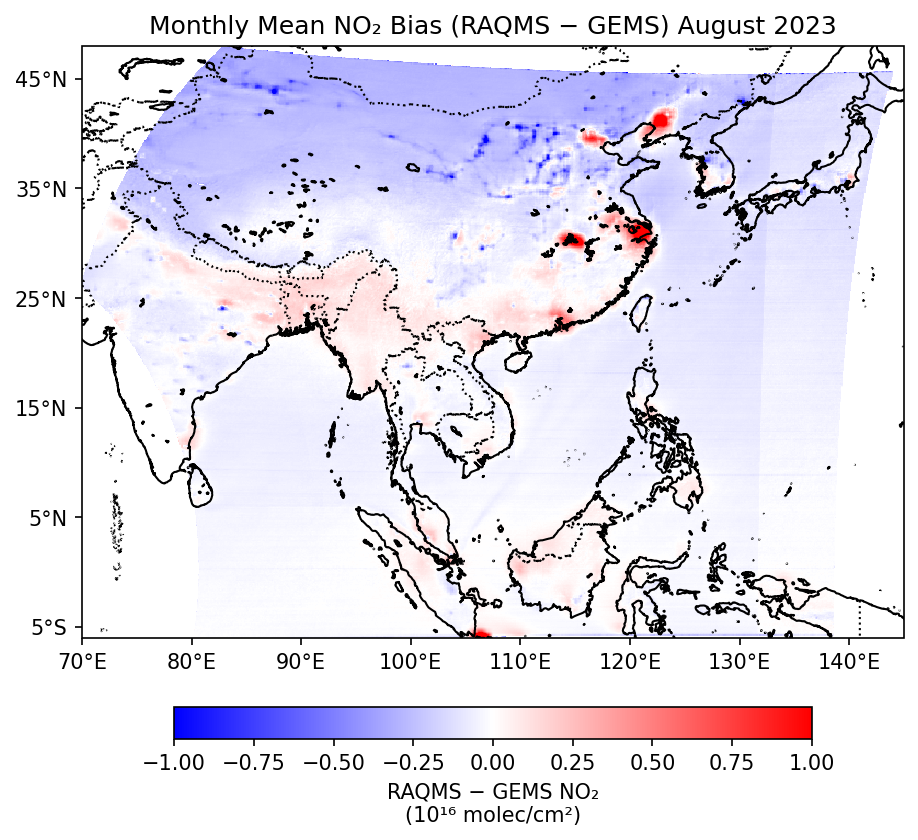

In [10]:
# File path
path = "/home/alubianashari/RAQMS_CloudMasked_GEMS/"
files = sorted(glob.glob(os.path.join(path, "tracer.compare.202308*.nc")))

# List to hold bias data
bias_stack = []

# Loop through files
for f in files:
    ds = xr.open_dataset(f)
    raqms = ds["no2_cloud_masked"].values
    gems = ds["gems_no2"].values

    # Mask invalid points
    valid = ~np.isnan(raqms) & ~np.isnan(gems)
    bias = np.full_like(raqms, np.nan)
    bias[valid] = raqms[valid] - gems[valid]

    bias_stack.append(bias)

# Stack and compute monthly mean
bias_array = np.stack(bias_stack)
monthly_mean_bias = np.nanmean(bias_array, axis=0)

# Extract coordinates
lat = ds["lat"].values
lon = ds["lon"].values

# Plot
vmin, vmax = -1, 1
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 145, -6, 48], crs=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE.with_scale('10m'))
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.LAKES.with_scale('10m'), edgecolor='black', facecolor='none')

mesh = ax.pcolormesh(lon, lat, monthly_mean_bias, cmap="bwr", vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
plt.colorbar(mesh, ax=ax, orientation='horizontal', label="RAQMS − GEMS NO₂\n(10¹⁶ molec/cm²)", fraction=0.046, pad=0.1)

ax.set_title("Monthly Mean NO₂ Bias (RAQMS − GEMS) August 2023")
ax.set_xticks(np.arange(70, 150, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-5, 50, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

plt.savefig("monthly_avg_GEMS/MonthlyBias_Aug2023.png", bbox_inches="tight")
plt.show()


In [12]:
# Find index of max bias
max_idx = np.unravel_index(np.nanargmax(monthly_mean_bias), monthly_mean_bias.shape)
i_max, j_max = max_idx

# Get value and coordinates
max_bias_value = monthly_mean_bias[i_max, j_max]
lat_max = lat[i_max]
lon_max = lon[j_max]

print(max_bias_value)
print(lat_max, lon_max)


2.5109632
-5.850000000000764 106.44999999999793


In [13]:
# Find index of min bias
min_idx = np.unravel_index(np.nanargmin(monthly_mean_bias), monthly_mean_bias.shape)
i_min, j_min = min_idx

# Get value and coordinates
min_bias_value = monthly_mean_bias[i_min, j_min]
lat_min = lat[i_min]
lon_min = lon[j_min]

print(min_bias_value)
print(lat_min, lon_min)


-1.6629401
39.34999999999988 106.9499999999979


In [14]:
idx = np.nanargmin(np.abs(monthly_mean_bias))
i0, j0 = np.unravel_index(idx, monthly_mean_bias.shape)

closest_value = monthly_mean_bias[i0, j0]
lat0 = lat[i0]
lon0 = lon[j0]

print(closest_value)
print(lat0, lon0)

-3.5812457e-07
30.949999999999758 86.54999999999906


In [19]:
# target coordinates
target_lat = 1.05
target_lon = 127.45

# index of closest grid point
i = np.abs(lat - target_lat).argmin()
j = np.abs(lon - target_lon).argmin()

print(lat[i], lon[j])

1.0499999999993335 127.44999999999673


In [20]:
dates = []
raqms_series = []
gems_series = []
bias_series = []

# Loop through daily files
for f in files:
    ds = xr.open_dataset(f)
    
    # Get date from filename
    date = os.path.basename(f).split(".")[2]
    dates.append(date)
    
    # Extract values at chosen i, j index
    raqms_val = ds["no2_cloud_masked"].values[i, j]
    gems_val = ds["gems_no2"].values[i, j]

    raqms_series.append(raqms_val)
    gems_series.append(gems_val)
    
    # Calculate bias only if both are valid
    if not np.isnan(raqms_val) and not np.isnan(gems_val):
        bias_series.append(raqms_val - gems_val)
    else:
        bias_series.append(np.nan)


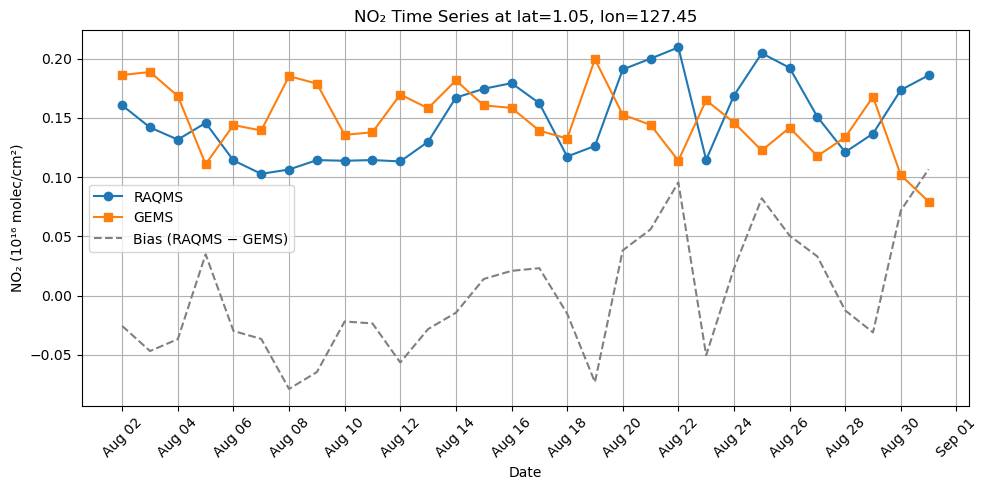

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

dates_dt = [datetime.strptime(d, "%Y%m%d") for d in dates]

plt.figure(figsize=(10, 5))
plt.plot(dates_dt, raqms_series, label="RAQMS", marker="o")
plt.plot(dates_dt, gems_series, label="GEMS", marker="s")
plt.plot(dates_dt, bias_series, label="Bias (RAQMS − GEMS)", linestyle="--", color="gray")

plt.title(f"NO₂ Time Series at lat={lat[i]:.2f}, lon={lon[j]:.2f}")
plt.ylabel("NO₂ (10¹⁶ molec/cm²)")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("monthly_avg_GEMS/TimeSeries_best.png")
plt.show()
